## Introduction

This is a notebook demonstrating interactive mapping functionalities with the Folium library. We worked with clustered markers, layers which can be switched on/off, and added a fullscreen button. 

The datasets are shapefiles coming from the Norwegian Petroleum Directorate, which is public data, and can be found here:
https://www.npd.no/en/about-us/information-services/available-data/map-services/. We used the wells and the production licences shapefiles.

This is a first version of this notebook, and we hope to add more functionalities in future. 

<b>Please note:</b> the map will not display if you are using Chrome. Please use FireFox or Safari instead. This issue has been reported.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
from folium.plugins import FastMarkerCluster
from folium.plugins import Fullscreen
from folium import FeatureGroup, LayerControl, Map, Marker

import requests
import json
import re
import urllib.request

import geopandas
from shapely.geometry import Point, Polygon, MultiPolygon
from IPython.display import IFrame

In [3]:
pd.set_option('display.max_rows', 8500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Let's get our wellbore dataset into a geopandas dataframe

In [4]:
# get the shapefile zip file from NPD website for wellbores
url = 'https://npdfactpages.npd.no/downloads/shape/wlbPoint.zip'
urllib.request.urlretrieve(url, '../data/wlbPoint.zip') # change path to your local directory

('../data/wlbPoint.zip', <http.client.HTTPMessage at 0x11739fd50>)

In [5]:
# read the shapefile zipped file into a geopandas dataframe
wells_explo = geopandas.read_file('zip://../data/wlbPoint.zip', encoding = 'utf-8') # change path to your local directory

In [6]:
wells_explo.shape

(8165, 118)

In [7]:
# let's add columns with coordinates so that it will be easy to use with our folium map definitions
wells_explo['wlbEwDesDeg'] = wells_explo['geometry'].x
wells_explo['wlbNsDecDeg'] = wells_explo['geometry'].y

In [8]:
# select only a few columns
wells_explo_sel = wells_explo.filter(['wbName', 'well_name', 'discovery', 'field', 'prodLicenc', 'well_type', 'drilOperat',
                                      'entryYear', 'cmplYear', 'content', 'main_area', 'totalDepth', 'age_at_TD', 'fmTD',
                                      'discWelbor', 'geometry', 'wlbEwDesDeg', 'wlbNsDecDeg'],
                                                axis=1)

Let's select only EXPLORATION wells and create a new dataframe

In [9]:
wells_explo_all = wells_explo_sel.loc[wells_explo_sel['well_type'].isin(['EXPLORATION'])]

In [10]:
wells_explo_all.shape

(1925, 18)

In [11]:
wells_explo_all.head()

,wbName,well_name,discovery,field,prodLicenc,well_type,drilOperat,entryYear,cmplYear,content,main_area,totalDepth,age_at_TD,fmTD,discWelbor,geometry,wlbEwDesDeg,wlbNsDecDeg
0,1/3-4,1/3-4,None,None,065,EXPLORATION,Elf Petroleum Norge AS,1983,1983,OIL SHOWS,NORTH SEA,3198.0,LATE PERMIAN,ZECHSTEIN GP,NO,POINT (2.71673 56.94423),2.716731,56.944225
1,2/2-3,2/2-3,None,None,066,EXPLORATION,Saga Petroleum ASA,1983,1983,DRY,NORTH SEA,4100.0,TRIASSIC,SMITH BANK FM,NO,POINT (3.42726 56.79345),3.427261,56.793450
2,30/6-12,30/6-12,30/6-1 Oseberg,OSEBERG,053,EXPLORATION,Norsk Hydro Produksjon AS,1983,1983,NOT APPLICABLE,NORTH SEA,615.0,PLIOCENE,NORDLAND GP,NO,POINT (2.82314 60.55433),2.823142,60.554331
3,34/10-17,34/10-17,34/10-17 Rimfaks,GULLFAKS SØR,050,EXPLORATION,Den norske stats oljeselskap a.s,1983,1983,OIL/GAS,NORTH SEA,3466.0,EARLY JURASSIC,STATFJORD GP,YES,POINT (2.01411 61.06637),2.014106,61.066369
4,31/2-11,31/2-11,31/2-1 (Troll Vest),TROLL,054,EXPLORATION,A/S Norske Shell,1983,1983,OIL/GAS,NORTH SEA,1744.0,MIDDLE JURASSIC,FENSFJORD FM,NO,POINT (3.42504 60.82438),3.425044,60.824378


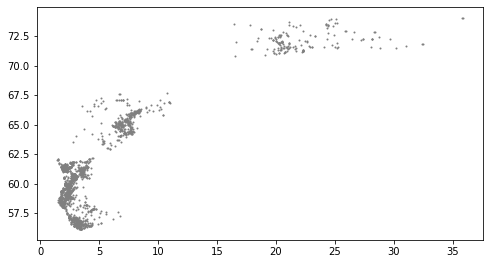

In [12]:
# quick plot of our exploration wells geopandas for overall QC
wells_explo_all.plot(figsize=(8,8), color='grey', markersize = 1)

### We would like to also add other layers on our map, for instance production licences

In [13]:
# get the shapefile zip file from NPD website for production licences
url = 'https://npdfactpages.npd.no/downloads/shape/prlAreaCurrent.zip'

urllib.request.urlretrieve(url, '../data/prlAreaCurrent.zip') # change path to your local directory

('../data/prlAreaCurrent.zip', <http.client.HTTPMessage at 0x118407550>)

In [14]:
# read the shapefile zipped file into a geopandas dataframe
prod_licences = geopandas.read_file('zip://../data/prlAreaCurrent.zip', encoding = 'utf-8') # change path to your local directory

In [15]:
prod_licences.shape

(1386, 24)

We are now going to remove the 'inactive' production licences which have no geometry (geometry = None)

In [16]:
prod_lic_active = prod_licences[prod_licences.status != 'INACTIVE']

In [17]:
prod_lic_active.shape

(567, 24)

In [18]:
# re-indexing geopandas
prod_lic_active = prod_lic_active.reset_index(drop=True)

In [19]:
prod_lic_active.head()

,idLicence,idLicRound,plName,RoundName,status,active,FactUrl,MapUrl,dtGranted,dtValTo,origArea,curArea,dtInitExpi,initPeriod,dtChanged,OpLongName,OperatrURL,idCompany,main_area,phaseCurr,dtUpdated,dtUpdMax,Stratigra,geometry
0,20756,74.0,001,1-A,ACTIVE,Y,https://factpages.npd.no/factpages/default.asp...,https://factmaps.npd.no/factmaps/3_0/?run=Lice...,1965-09-01,2030-03-01,2145.855,100.779,1971-08-31,NO,2019-08-06,Vår Energi AS,https://factpages.npd.no/factpages/default.asp...,33360957,North Sea,PRODUCTION EXTENDED,2019-10-02,2019-10-02,YES OR PARTLY,"POLYGON ((2.33333 59.13333, 2.33333 59.13333, ..."
1,20804,74.0,006,1-A,ACTIVE,Y,https://factpages.npd.no/factpages/default.asp...,https://factmaps.npd.no/factmaps/3_0/?run=Lice...,1965-09-01,2028-12-31,2278.556,37.960,1971-08-31,NO,2009-01-29,Total E&P Norge AS,https://factpages.npd.no/factpages/default.asp...,2410708,North Sea,PRODUCTION EXTENDED,2019-10-02,2019-10-02,NO,"POLYGON ((3.33333 56.60833, 3.33333 56.60833, ..."
2,20900,74.0,018,1-A,ACTIVE,Y,https://factpages.npd.no/factpages/default.asp...,https://factmaps.npd.no/factmaps/3_0/?run=Lice...,1965-09-01,2028-12-31,1752.704,851.767,1971-08-31,NO,2018-12-10,ConocoPhillips Skandinavia AS,https://factpages.npd.no/factpages/default.asp...,2410696,North Sea,PRODUCTION EXTENDED,2019-10-02,2019-10-02,NO,"MULTIPOLYGON (((3.13333 56.25000, 3.13333 56.2..."
3,20908,105.0,018 B,Awarded additionally to round 1-A,ACTIVE,Y,https://factpages.npd.no/factpages/default.asp...,https://factmaps.npd.no/factmaps/3_0/?run=Lice...,1995-08-25,2028-12-31,102.503,55.050,1998-12-31,NO,2018-12-10,ConocoPhillips Skandinavia AS,https://factpages.npd.no/factpages/default.asp...,2410696,North Sea,PRODUCTION,2019-10-02,2019-10-02,NO,"POLYGON ((2.91667 56.60000, 2.91667 56.60000, ..."
4,20916,74.0,019,1-A,ACTIVE,Y,https://factpages.npd.no/factpages/default.asp...,https://factmaps.npd.no/factmaps/3_0/?run=Lice...,1965-09-01,2029-01-01,1686.393,101.217,1971-08-31,NO,2019-05-22,Aker BP ASA,https://factpages.npd.no/factpages/default.asp...,28544099,North Sea,PRODUCTION EXTENDED,2019-10-02,2019-10-02,NO,"POLYGON ((2.80000 57.05000, 2.80000 57.05000, ..."


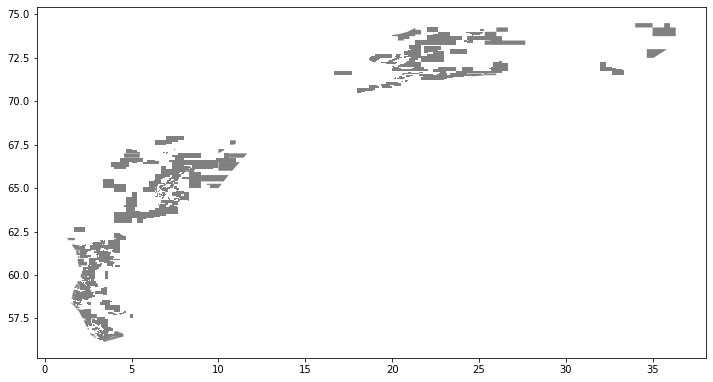

In [20]:
# quick plot of our licence geopandas for overall QC
prod_lic_active.plot(figsize=(12,12), color='grey')

#### Let's check if we have n/a values for our geometries, since this will be invalid polygons for our map

In [21]:
prod_lic_active.isna().sum()

idLicence     0
idLicRound    0
plName        0
RoundName     0
status        0
active        0
FactUrl       0
MapUrl        0
dtGranted     0
dtValTo       0
origArea      0
curArea       0
dtInitExpi    0
initPeriod    0
dtChanged     0
OpLongName    0
OperatrURL    0
idCompany     0
main_area     0
phaseCurr     2
dtUpdated     0
dtUpdMax      0
Stratigra     0
geometry      1
dtype: int64

In [22]:
# find which rows in prod_lic_active have n/a values!
null_data = prod_lic_active[prod_lic_active.isnull().any(axis=1)]
null_data

,idLicence,idLicRound,plName,RoundName,status,active,FactUrl,MapUrl,dtGranted,dtValTo,origArea,curArea,dtInitExpi,initPeriod,dtChanged,OpLongName,OperatrURL,idCompany,main_area,phaseCurr,dtUpdated,dtUpdMax,Stratigra,geometry
158,3810636,150.0,364,TFO2005,ACTIVE,Y,https://factpages.npd.no/factpages/default.asp...,https://factmaps.npd.no/factmaps/3_0/?run=Lice...,2006-01-06,2019-01-06,104.386,32.204,2009-01-06,NO,2017-08-01,Aker BP ASA,https://factpages.npd.no/factpages/default.asp...,28544099,North Sea,None,2019-10-02,2019-10-02,NO,"POLYGON ((2.51667 59.69167, 2.51667 59.69167, ..."
347,28941798,200.0,442 B,TFO2016,ACTIVE,Y,https://factpages.npd.no/factpages/default.asp...,https://factmaps.npd.no/factmaps/3_0/?run=Lice...,2017-02-10,2017-06-15,41.686,41.686,2017-06-15,NO,2017-03-21,Aker BP ASA,https://factpages.npd.no/factpages/default.asp...,28544099,North Sea,None,2019-11-18,2019-10-02,NO,"POLYGON ((2.58333 59.76667, 2.58333 59.76667, ..."
566,35358709,74.0,018 ES,1-A,ACTIVE,Y,https://factpages.npd.no/factpages/default.asp...,https://factmaps.npd.no/factmaps/3_0/?run=Lice...,2019-12-06,2028-12-31,24.028,24.028,2028-12-31,NO,2019-12-11,Total E&P Norge AS,https://factpages.npd.no/factpages/default.asp...,2410708,North Sea,PRODUCTION,2019-12-12,2019-12-12,YES OR PARTLY,None


--> We see that one of the rows have n/a (None) in 'geometry'. This will cause problems in our map, so we exclude this row from the df.

In [23]:
prod_lic_active = prod_lic_active[pd.notnull(prod_lic_active['geometry'])]

In [24]:
# exploding the multipolygons into single polygons
prod_lic_expl = prod_lic_active.explode()

In [25]:
prod_lic_expl.shape

(619, 24)

In [26]:
# re-indexing
prod_lic_expl = prod_lic_expl.reset_index(drop=True)

In [27]:
# prod_lic_expl.head()

In [28]:
# reduce number of polygons in geodataframe to test display speed (max for display in Chrome is 145 polygons)
# prod_lic_mini = prod_lic_expl.sample(n = 145)

Convert our geopandas to geojson file

In [29]:
prod_lic_expl.to_file('../data/prod_lic_expl.geojson', driver='GeoJSON')

### Creating map with Folium
<b>Please note:</b> the map will not display if you are using Chrome. Please use FireFox or Safari instead. This issue has been reported.

In [30]:
# creating a map that's centered on our sample
map_wells = folium.Map(location=[wells_explo_all['wlbNsDecDeg'].mean(), 
                                 wells_explo_all['wlbEwDesDeg'].mean()], 
                                 zoom_start=5,
                                 tiles='cartodbpositron'
                      )

fs = Fullscreen()

tile = folium.TileLayer('OpenStreetMap').add_to(map_wells) # adding an extra map background in the layer menu

# adding production licences to map, with style function for fill colour, outline, outline weight
# folium.GeoJson(
#     '../data/prod_lic_expl.geojson',
#      name='Prod licences',
#      style_function=lambda x: {'fillColor':'grey',
#                                'color': 'white',
#                                'weight': 0.2}
# ).add_to(map_wells)
    
# defining parameters for our markers and the popups when clicking on single markers 
callback = ('function (row) {' 
                'var marker = L.marker(new L.LatLng(row[0], row[1]));'
                'var icon = L.AwesomeMarkers.icon({'
                "icon: 'star',"
                "iconColor: 'black',"
                "markerColor: 'lightgray',"
                    '});'
                'marker.setIcon(icon);'
                "var popup = L.popup({maxWidth: '300'});"
                "const display_text = {text: '<b>Name: </b>' + row[2] + '</br>' + '<b> Age at TD: </b>' + row[3]};"
                "var mytext = $(`<div id='mytext' class='display_text' style='width: 100.0%; height: 100.0%;'> ${display_text.text}</div>`)[0];"
                "popup.setContent(mytext);"
                "marker.bindPopup(popup);"
                'return marker};')


# creating clusters with FastMarkerCluster
fmc = FastMarkerCluster(wells_explo_all[['wlbNsDecDeg', 'wlbEwDesDeg', 'wbName', 'age_at_TD']].values.tolist(), callback=callback)
fmc.layer_name = 'Exploration Wells'

map_wells.add_child(fmc) # adding fastmarkerclusters to map
map_wells.add_child(fs) # adding fullscreen button to map

folium.LayerControl().add_to(map_wells) # adding layers to map

map_wells